# Process All Data
Get all of the data together. This includes data during formation and aging cycles. Aging cycles include the diagnostic tests as well as the 1C/1C charge/discharge. Summarize the results and plot correlations.

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd
import glob
import pprint
from datetime import datetime
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt
import re
from src.formation import FormationCell

In [2]:
assert os.path.basename(os.getcwd()) == 'project-formation'

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Times New Roman'],
                  'size': 26
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (10, 8)
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=True)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


DPI = 600
VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

ORANGE = (1, 0.5, 0)
BLUE = (0, 0.5, 1)
BLACK = (0.0, 0.0, 0.0)
GREEN = (0, 0.75, 0)
ORANGE = (1, 0.5, 0)

## Load resources

In [4]:
formation_cells = []
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    formation_cells.append(FormationCell(cellid))
    
for cell in formation_cells:
    print(cell)

Formation Cell 1
Formation Cell 2
Formation Cell 3
Formation Cell 4
Formation Cell 5
Formation Cell 6
Formation Cell 7
Formation Cell 8
Formation Cell 9
Formation Cell 10
Formation Cell 11
Formation Cell 12
Formation Cell 13
Formation Cell 14
Formation Cell 15
Formation Cell 16
Formation Cell 17
Formation Cell 18
Formation Cell 19
Formation Cell 20
Formation Cell 21
Formation Cell 22
Formation Cell 23
Formation Cell 24
Formation Cell 25
Formation Cell 26
Formation Cell 27
Formation Cell 28
Formation Cell 29
Formation Cell 30
Formation Cell 31
Formation Cell 32
Formation Cell 33
Formation Cell 34
Formation Cell 35
Formation Cell 36
Formation Cell 37
Formation Cell 38
Formation Cell 39
Formation Cell 40


## Plot cycles to x% Retention

In [5]:
# Get the data
results_list = []

for cell in formation_cells:
    
    print(f'Processing cell {cell}...')
    
    if cell.cellid == 9:
        continue
        
    stats_dict = cell.get_aging_test_summary_statistics()

    for retention in np.array([80]):

        curr_dict = dict()
        curr_dict['cellid'] = cell.cellid
        curr_dict['is_room_temp'] = cell.is_room_temp()
        curr_dict['formation_type'] = 'Baseline Formation' if cell.is_baseline_formation() else 'Fast Formation'
        curr_dict['retention'] = retention
        curr_dict['cycles'] = stats_dict[f'cycles_to_{retention}_pct']
            
        results_list.append(curr_dict)
        
df = pd.DataFrame(results_list)
df['retention'] = df['retention'].astype('category')


df_room_temp = df[df['is_room_temp'] == 1]
df_high_temp = df[df['is_room_temp'] == 0]

Processing cell Formation Cell 1...
Processing cell Formation Cell 2...
Processing cell Formation Cell 3...
Processing cell Formation Cell 4...
Processing cell Formation Cell 5...
Processing cell Formation Cell 6...
Processing cell Formation Cell 7...
Processing cell Formation Cell 8...
Processing cell Formation Cell 9...
Processing cell Formation Cell 10...
Processing cell Formation Cell 11...
Processing cell Formation Cell 12...
Processing cell Formation Cell 13...
Processing cell Formation Cell 14...
Processing cell Formation Cell 15...
Processing cell Formation Cell 16...
Processing cell Formation Cell 17...
Processing cell Formation Cell 18...
Processing cell Formation Cell 19...
Processing cell Formation Cell 20...
Processing cell Formation Cell 21...
Processing cell Formation Cell 22...
Processing cell Formation Cell 23...
Processing cell Formation Cell 24...
Processing cell Formation Cell 25...
Processing cell Formation Cell 26...
Processing cell Formation Cell 27...
Processing

In [6]:
%pdb

Automatic pdb calling has been turned ON


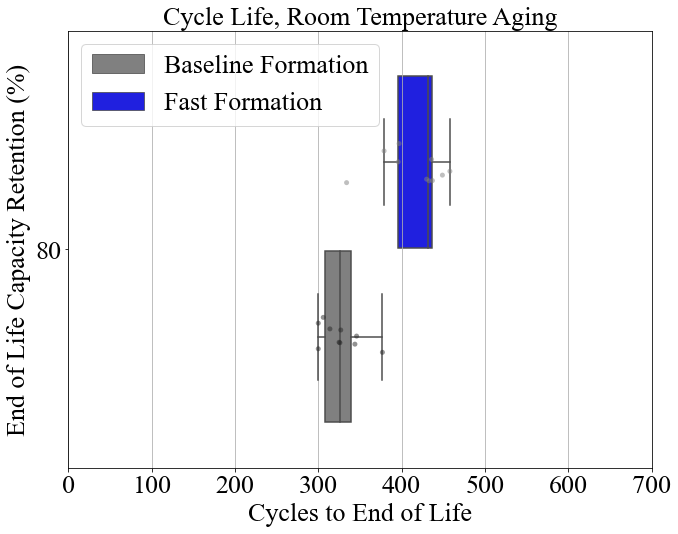

In [7]:
# Make the box plot

bp = sns.boxplot(x='cycles', y='retention',
                 data=df_room_temp,
                 palette=['grey', 'b'],
                 hue='formation_type',
                 showfliers=False
                )

bp = sns.stripplot(x='cycles', y='retention', 
                   data=df_room_temp, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.5,
                   hue='formation_type',
                   color='grey')

bp.set(xlabel='Cycles to End of Life',
       xlim=(0,700),
       ylabel='End of Life Capacity Retention (%)',
       title='Cycle Life, Room Temperature Aging')

bp.invert_yaxis()

handles, labels = bp.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

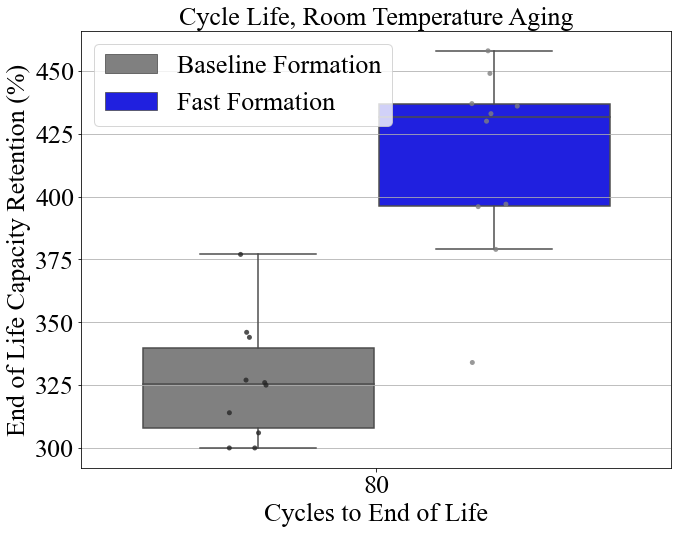

In [8]:
bp = sns.boxplot(x='retention', y='cycles',
                 data=df_room_temp,
                 palette=['grey', 'b'],
                 hue='formation_type',
                 showfliers=False
                )

bp = sns.stripplot(x='retention', y='cycles', 
                   data=df_room_temp, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.8,
                   hue='formation_type',
                   color='grey')

bp.set(xlabel='Cycles to End of Life',
       ylabel='End of Life Capacity Retention (%)',
       title='Cycle Life, Room Temperature Aging')

handles, labels = bp.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

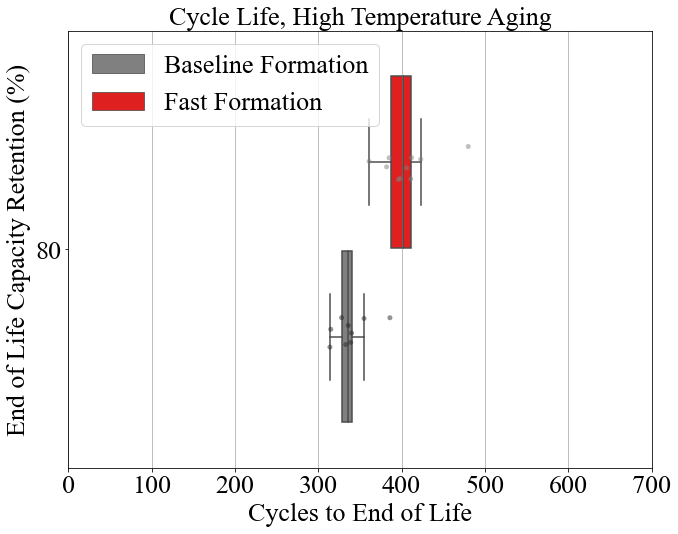

In [9]:
bp = sns.boxplot(x='cycles', y='retention',
                 data=df_high_temp,
                 palette=['grey', 'r'],
                 hue='formation_type',
                 showfliers=False
                )

bp = sns.stripplot(x='cycles', y='retention', 
                   data=df_high_temp, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.5,
                   hue='formation_type',
                   color='grey')

bp.set(xlabel='Cycles to End of Life',
       ylabel='End of Life Capacity Retention (%)',
       xlim=(0,700),
       title='Cycle Life, High Temperature Aging')

bp.invert_yaxis()

handles, labels = bp.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

## Compute statistical significance for cycles to x% retention

In [10]:
result = list()

for ret in df.retention.unique():
    
    for is_room_temp in [0, 1]:
        
        df_subset = df[(df['retention'] == ret) & 
                       (df['is_room_temp'] == is_room_temp)]

        set_fast = df_subset[df_subset['formation_type'] == 'Fast Formation']['cycles'].dropna()
        set_baseline = df_subset[df_subset['formation_type'] == 'Baseline Formation']['cycles'].dropna()

        stat, p = ttest_ind(set_fast, set_baseline)

        curr_result = dict()
        curr_result['retention_target'] = ret
        curr_result['p_value'] = p
        curr_result['is_room_temp'] = is_room_temp
        curr_result['temp'] = 'rt' if is_room_temp else 'ht'
        curr_result['stdev_fast'] = np.std(set_fast)
        curr_result['stdev_base'] = np.std(set_baseline)

        result.append(curr_result)

df_result = pd.DataFrame(result)

display(df_result)


,retention_target,p_value,is_room_temp,temp,stdev_fast,stdev_base
0,80,0.000059,0,ht,30.047296,20.629596
1,80,0.000007,1,rt,36.084484,22.848414


In [11]:
df

,cellid,is_room_temp,formation_type,retention,cycles
0,1,False,Baseline Formation,80,328
1,2,False,Baseline Formation,80,314
2,3,False,Baseline Formation,80,386
3,4,False,Baseline Formation,80,315
4,5,False,Baseline Formation,80,333
5,6,False,Baseline Formation,80,355
6,7,False,Baseline Formation,80,336
7,8,False,Baseline Formation,80,340
8,10,False,Baseline Formation,80,339
9,11,True,Baseline Formation,80,346


## Process the data from the Diagnostic Cycles

## Load the eSOH Parameters

In [12]:
ESOH_FILE = 'output/2020-10-esoh-results-summary/y100-fix/summary_esoh_table.csv'

df_esoh = pd.read_csv(ESOH_FILE)

# Exclude cell 9
df_esoh = df_esoh[df_esoh['cellid'] != 9]

# Exclude high RMSE
# df_esoh = df_esoh[df_esoh['RMSE_mV'] < 120]

df_esoh = df_esoh.sort_values(by=['cellid', 'cycle_number'])

# Compute more metrics
df_esoh = df_esoh.merge(df_esoh.groupby(['cellid'])['n_li'].first().rename('n_li_0'), on='cellid')
df_esoh = df_esoh.merge(df_esoh.groupby(['cellid'])['Cp'].first().rename('Cp_0'), on='cellid')
df_esoh = df_esoh.merge(df_esoh.groupby(['cellid'])['Cn'].first().rename('Cn_0'), on='cellid')
df_esoh = df_esoh.merge(df_esoh.groupby(['cellid'])['Qfull'].first().rename('Qfull_0'), on='cellid')

df_esoh['lli'] = (1 - df_esoh['n_li'] / df_esoh['n_li_0']) * 100
df_esoh['lam_pe'] = (1 - df_esoh['Cp'] / df_esoh['Cp_0']) * 100
df_esoh['lam_ne'] = (1 - df_esoh['Cn'] / df_esoh['Cn_0']) * 100
df_esoh['c20_loss'] = (1 - df_esoh['Qfull'] / df_esoh['Qfull_0']) * 100

df_esoh_rt_base = df_esoh[df_esoh['cellid'].isin([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])]
df_esoh_rt_fast = df_esoh[df_esoh['cellid'].isin([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])]
df_esoh_ht_base = df_esoh[df_esoh['cellid'].isin([1, 2, 3, 4, 5, 6, 7, 8])] # Exclude cell #9
df_esoh_ht_fast = df_esoh[df_esoh['cellid'].isin([31, 32, 33, 34, 35, 36, 37, 38, 39, 40])]

In [13]:
# Define helper function here

def add_mean_line(ax, df, varname, color):
    
    df_mean = df.groupby('cycle_number').mean()
    df_std = df.groupby('cycle_number').std()
    
    std = df_std[varname]
    mean = df_mean[varname]
    
    ax.plot(df_mean.index, mean, 
            linewidth=2.5, 
            color=color, 
            marker='o', 
            markersize=4)
    
    ax.fill_between(df_mean.index, (mean - 2*std), (mean + 2*std), 
                    color=color, 
                    alpha=0.1, 
                    linewidth=0.0)

In [14]:
# Build a full list of HPPC data for all cells

df_hppc_all = pd.DataFrame()

df_hppc_list = []

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    df_hppc = cell.summarize_hppc_pulse_statistics()
    df_hppc['cellid'] = cell.cellid
    df_hppc['cycle_number'] = df_hppc['cycle_index']
    df_hppc['dcr_soc_0']*=1000;
    df_hppc['dcr_soc_50']*=1000;
    df_hppc['dcr_soc_100']*=1000;
    df_hppc_list.append(df_hppc)
    
df_hppc_all = pd.concat(df_hppc_list)

df_hppc_rt_base = df_hppc_all[df_hppc_all['cellid'].isin([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])]
df_hppc_rt_fast = df_hppc_all[df_hppc_all['cellid'].isin([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])]
df_hppc_ht_base = df_hppc_all[df_hppc_all['cellid'].isin([1, 2, 3, 4, 5, 6, 7, 8])] # Exclude cell #9
df_hppc_ht_fast = df_hppc_all[df_hppc_all['cellid'].isin([31, 32, 33, 34, 35, 36, 37, 38, 39, 40])]

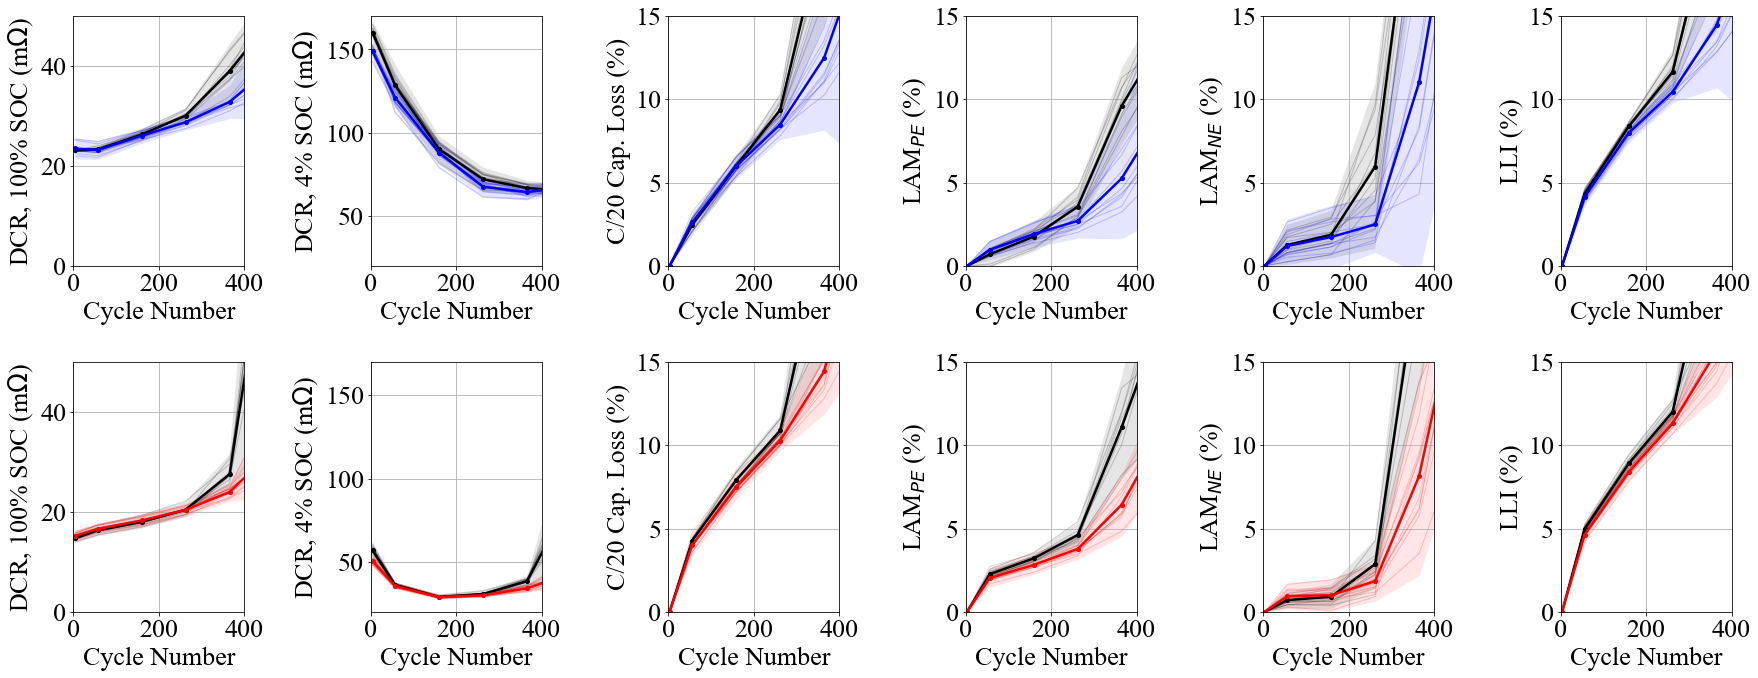

In [15]:
fig, axs = plt.subplots(2, 6, figsize=(25,10))

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue

    df_hppc = cell.summarize_hppc_pulse_statistics()
    df_esoh_curr = df_esoh[df_esoh['cellid'] == cell.cellid]
    
    if cell.is_room_temp():    
        color = 'k' if cell.is_baseline_formation() else 'b'
        i = 0
    else:
        color = 'k' if cell.is_baseline_formation() else 'r'
        i = 1
        
    axs[i,0].plot(df_hppc['cycle_index'], df_hppc['dcr_soc_100']*1000, 
                color=color, linewidth=1,alpha=0.2)   
    axs[i,1].plot(df_hppc['cycle_index'], df_hppc['dcr_soc_0']*1000, 
                color=color, markersize=4, alpha=0.2)
    axs[i,2].plot(df_esoh_curr['cycle_number'], df_esoh_curr['c20_loss'],
                color=color, linewidth=1,alpha=0.2) 
    axs[i,3].plot(df_esoh_curr['cycle_number'], df_esoh_curr['lam_pe'], 
                color=color, linewidth=1, alpha=0.2)   
    axs[i,4].plot(df_esoh_curr['cycle_number'], df_esoh_curr['lam_ne'], 
                color=color, linewidth=1, alpha=0.2)
    axs[i,5].plot(df_esoh_curr['cycle_number'], df_esoh_curr['lli'], 
                color=color, linewidth=1, alpha=0.2)
    
add_mean_line(axs[0, 0], df_hppc_rt_base, 'dcr_soc_100', 'k')
add_mean_line(axs[0, 1], df_hppc_rt_base, 'dcr_soc_0', 'k')
add_mean_line(axs[0, 2], df_esoh_rt_base, 'c20_loss', 'k')
add_mean_line(axs[0, 3], df_esoh_rt_base, 'lam_pe', 'k')
add_mean_line(axs[0, 4], df_esoh_rt_base, 'lam_ne', 'k')
add_mean_line(axs[0, 5], df_esoh_rt_base, 'lli', 'k')

add_mean_line(axs[0, 0], df_hppc_rt_fast, 'dcr_soc_100', 'b')
add_mean_line(axs[0, 1], df_hppc_rt_fast, 'dcr_soc_0', 'b')
add_mean_line(axs[0, 2], df_esoh_rt_fast, 'c20_loss', 'b')
add_mean_line(axs[0, 3], df_esoh_rt_fast, 'lam_pe', 'b')
add_mean_line(axs[0, 4], df_esoh_rt_fast, 'lam_ne', 'b')
add_mean_line(axs[0, 5], df_esoh_rt_fast, 'lli', 'b')

add_mean_line(axs[1, 0], df_hppc_ht_base, 'dcr_soc_100', 'k')
add_mean_line(axs[1, 1], df_hppc_ht_base, 'dcr_soc_0', 'k')
add_mean_line(axs[1, 2], df_esoh_ht_base, 'c20_loss', 'k')
add_mean_line(axs[1, 3], df_esoh_ht_base, 'lam_pe', 'k')
add_mean_line(axs[1, 4], df_esoh_ht_base, 'lam_ne', 'k')
add_mean_line(axs[1, 5], df_esoh_ht_base, 'lli', 'k')

add_mean_line(axs[1, 0], df_hppc_ht_fast, 'dcr_soc_100', 'r')
add_mean_line(axs[1, 1], df_hppc_ht_fast, 'dcr_soc_0', 'r')
add_mean_line(axs[1, 2], df_esoh_ht_fast, 'c20_loss', 'r')
add_mean_line(axs[1, 3], df_esoh_ht_fast, 'lam_pe', 'r')
add_mean_line(axs[1, 4], df_esoh_ht_fast, 'lam_ne', 'r')
add_mean_line(axs[1, 5], df_esoh_ht_fast, 'lli', 'r')


for i in [0, 1]:
    
    axs[i, 0].set(ylabel='DCR, 100% SOC (m$\Omega$)') 
    axs[i, 1].set(ylabel='DCR, 4% SOC (m$\Omega$)')
    axs[i, 2].set(ylabel='C/20 Cap. Loss (%)')
    axs[i, 3].set(ylabel='LAM$_{PE}$ (%)')
    axs[i, 4].set(ylabel='LAM$_{NE}$ (%)')
    axs[i, 5].set(ylabel='LLI (%)')
    
    axs[i, 0].set(ylim=(0, 50))
    axs[i, 1].set(ylim=(20, 170))
    axs[i, 2].set(ylim=(0, 15))
    axs[i, 3].set(ylim=(0, 15))
    axs[i, 4].set(ylim=(0, 15))
    axs[i, 5].set(ylim=(0, 15))

[ax.set(xlim=(0, 400), xlabel='Cycle Number') for ax in axs.flatten()]

plt.tight_layout()
plt.savefig('aging_test_metrics.png', dpi=DPI, facecolor='w')
plt.show()


## Cell initial DCR as a function of SOC for all cells

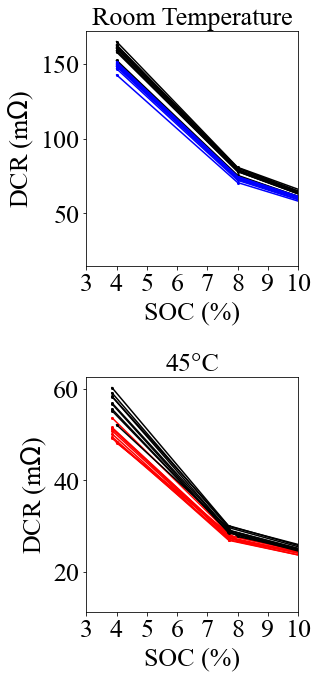

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

np.random.shuffle(formation_cells)
for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    ax = axs[0] if cell.is_room_temp() else axs[1]
    title = 'Room Temperature' if cell.is_room_temp() else '45°C'
    
    hppc_dict = cell.process_diagnostic_hppc_data()
        
    cap = hppc_dict[0]['data']['capacity']
    dcr = hppc_dict[0]['data']['resistance']*1000
    
    soc = cap/np.max(cap)*100
        
    color = (0, 0, 1) if cell.is_room_temp() else (1, 0, 0)
    color = (0, 0, 0) if cell.is_baseline_formation() else color
    
    ax.plot(soc, dcr, color=color, marker='o', markersize=2)
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100])
    ax.set_xlim((3, 10))
    ax.set_title(title)
    
[ax.set(ylabel='DCR (m$\Omega$)') for ax in axs]
[ax.set(xlabel='SOC (%)') for ax in axs]
[ax.grid(False) for ax in axs]

plt.show()

### C/20 and C/3 discharge capacities

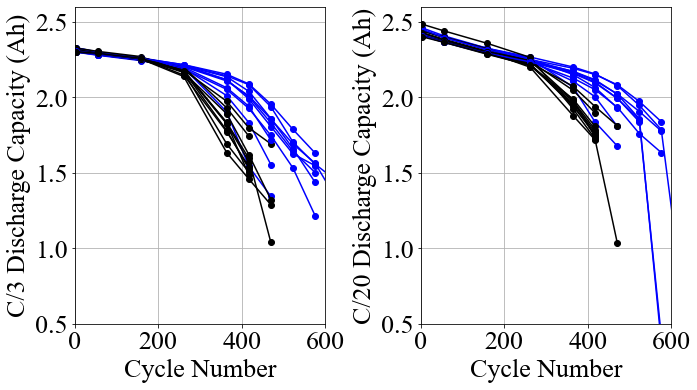

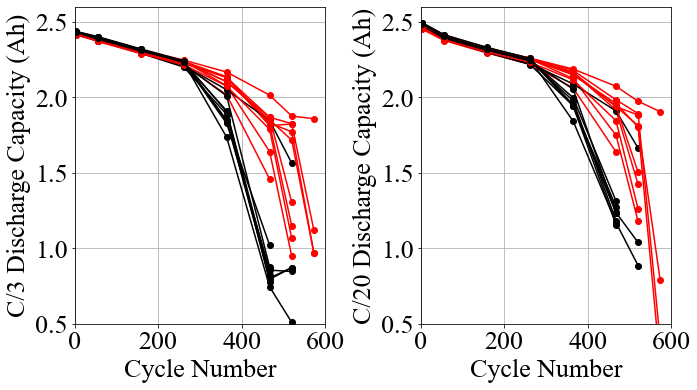

In [17]:
# Room temperature

fig, axs = plt.subplots(1, 2, figsize=(10,6))

for cell in formation_cells:

    if cell.cellid == 9:
        continue
        
    if cell.is_room_temp():
        
        results_c3 = cell.process_diagnostic_c3_data()
        results_c20 = cell.process_diagnostic_c20_data()

        # Unpack the relevant data content for the current cell
        cycle_index_c3 = []
        discharge_capacity_c3 = []
        
        for res in results_c3:
            if not res['dch_capacity'].empty:
                cycle_index_c3.append(res['cycle_index'])
                discharge_capacity_c3.append(res['dch_capacity'].iloc[-1])

        cycle_index_c20 = []
        discharge_capacity_c20 = []
        
        for res in results_c20:
            if not res['dch_capacity'].empty:
                cycle_index_c20.append(res['cycle_index'])
                discharge_capacity_c20.append(res['dch_capacity'].iloc[-1])
                        
        color = (0,0,0) if cell.is_baseline_formation() else (0,0,1)
        axs[0].plot(cycle_index_c3, discharge_capacity_c3, color=color, marker='o')  
        axs[1].plot(cycle_index_c20, discharge_capacity_c20, color=color, marker='o')
        axs[0].set(ylabel='C/3 Discharge Capacity (Ah)')
        axs[1].set(ylabel='C/20 Discharge Capacity (Ah)')
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           xlim=(0, 600),
           ylim=(0.5, 2.6)
          )

plt.tight_layout()
plt.show()


# High temperatures
fig, axs = plt.subplots(1, 2, figsize=(10,6))

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
    
    if not cell.is_room_temp():
                
        results_c3 = cell.process_diagnostic_c3_data()
        results_c20 = cell.process_diagnostic_c20_data()

        # Unpack the relevant data content for the current cell
        cycle_index_c3 = []
        discharge_capacity_c3 = []
        
        for res in results_c3:
            if not res['dch_capacity'].empty:
                cycle_index_c3.append(res['cycle_index'])
                discharge_capacity_c3.append(res['dch_capacity'].iloc[-1])

        cycle_index_c20 = []
        discharge_capacity_c20 = []
        
        for res in results_c20:
            if not res['dch_capacity'].empty:
                cycle_index_c20.append(res['cycle_index'])
                discharge_capacity_c20.append(res['dch_capacity'].iloc[-1])
        
        color = (0,0,0) if cell.is_baseline_formation() else (1,0,0)
        
        axs[0].plot(cycle_index_c3, discharge_capacity_c3, color=color, marker='o')   
        axs[1].plot(cycle_index_c20, discharge_capacity_c20, color=color, marker='o')
        axs[0].set(ylabel='C/3 Discharge Capacity (Ah)')
        axs[1].set(ylabel='C/20 Discharge Capacity (Ah)')
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           xlim=(0, 600),
           ylim=(0.5, 2.6)
          )

plt.tight_layout()
plt.show()

## Get the summary statistics for each cell

In [ ]:
all_summary_data = []

for cell in formation_cells:
    
    curr_summary = dict()
    
    curr_summary.update(cell.get_formation_test_summary_statistics())
    curr_summary.update(cell.get_aging_test_summary_statistics())
    curr_summary['is_room_temp_aging'] = 1 if cell.is_room_temp() else 0
    curr_summary['is_baseline_formation'] = 1 if cell.is_baseline_formation() else 0
    curr_summary['is_plating'] = 1 if cell.is_plating() else 0
    curr_summary['swelling_severity'] = cell.get_swelling_severity()
    curr_summary['thickness_mm'] = cell.get_thickness()
    curr_summary['electrolyte_weight_g'] = cell.get_electrolyte_weight()
    curr_summary['form_coulombic_efficiency'] = curr_summary['form_final_discharge_capacity_ah'] / curr_summary['form_first_charge_capacity_ah']
    curr_summary['cellid'] = cell.cellid
    all_summary_data.append(curr_summary)
    
df_corr = pd.DataFrame(all_summary_data)

In [ ]:
df_corr.columns

In [ ]:
df_corr.to_csv('correlation_data.csv')

## Make some correlation plots

In [ ]:
sns.set_theme(style="ticks")

df_plot = df_corr.drop(columns=['initial_capacity_std', 
                                'cycles_to_50_pct', 
                                'cycles_to_70_pct', 
                                'cycles_to_80_pct',
                                'form_first_discharge_capacity_ah',
                                'form_first_cycle_efficiency',
                                'cellid'])

df_plot['swelling_severity'] = df_plot['swelling_severity'].astype(float)

sns_plot = sns.pairplot(df_plot[df_plot['is_room_temp_aging'] == True], 
                        hue='is_baseline_formation',
                        diag_kind='hist')

In [ ]:
sns_plot.savefig("output_room_temp.png")

In [ ]:
sns_plot = sns.pairplot(df_plot[df_plot['is_room_temp_aging'] == False], 
                        hue='is_baseline_formation',
                        diag_kind='hist')

In [ ]:
sns_plot.savefig("output_hot.png")

In [ ]:
# Drop cell 9 from hereon which is a clear outlier
df_corr = df_corr[df_corr['cellid'] != 9]
df_corr

In [ ]:
dfCorr = df_corr.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,30))
sns.heatmap(filteredDf, annot=True, cmap="coolwarm")
plt.savefig('correlation_matrix.png')
plt.show()
